In [188]:
using LinearAlgebra, Printf, Images, TestImages, Colors, Polynomials, Plots, DataFrames, Statistics

In [181]:
x = rand(1000)
A = rand(1000, 1000)
b = A * x

x1 = @time inv(A) * b
x2 = @time A \ b
x3 = @time factorize(A) \ b

println()

  0.134510 seconds (11 allocations: 8.130 MiB)
  0.032710 seconds (9 allocations: 7.641 MiB, 29.05% gc time)
  0.020059 seconds (9 allocations: 7.641 MiB)



In [182]:
abs(norm(x1) - norm(x))

2.3447910280083306e-13

In [183]:
abs(norm(x2) - norm(x))

1.2434497875801753e-13

In [184]:
abs(norm(x3) - norm(x))

1.2434497875801753e-13

In [185]:
function naive_multiplication(A,B)
    C=zeros(Float64,size(A,1),size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j]=C[i,j]+A[i,k]*B[k,j]
            end
        end
    end
    return(C)
end

naive_multiplication (generic function with 1 method)

In [186]:
naive = []
data = DataFrame(size = Int[], naive = Float64[])

range = 10:10:250
for size = range
    for i = 1:10
        m1 = rand(size, size)
        m2 = rand(size, size)
        naive = @elapsed naive_multiplication(m1, m2)
        push!(data, [size naive])
    end
end

In [187]:
processed = by(data, :size, df->DataFrame(naive_avg=mean(df[:naive]), naive_std=std(df[:naive])))

,size,naive_avg,naive_std
,Int64,Float64,Float64
1,10,0.00336921,0.0106475
2,20,1.69914e-5,1.37308e-7
3,30,6.0658e-5,4.65148e-7
4,40,0.000154588,1.53971e-5
5,50,0.000346775,6.63972e-5
6,60,0.000631846,6.16863e-5
7,70,0.00100597,0.000152151
8,80,0.00161029,7.78363e-5
9,90,0.00231242,0.000108171


In [189]:
polyfit(processed[:size], processed[:naive_avg], 4)

Poly(0.0016339120718577903 - 8.936960919570752e-6*x - 5.964471951740005e-7*x^2 + 9.128159782464673e-9*x^3 - 1.674226382700192e-11*x^4)

In [196]:
A = zeros(size(processed, 1), 5)
A[:,1] = processed[:size].^4
A[:,2] = processed[:size].^3
A[:,3] = processed[:size].^2
A[:,4] = processed[:size].^1
A[:,5] = processed[:size].^0

fit = A \ processed[:naive_avg]

5-element Array{Float64,1}:
 -1.674226382700192e-11
  9.128159782464673e-9 
 -5.964471951740005e-7 
 -8.936960919570752e-6 
  0.0016339120718577903

In [199]:
function compress_matrix(A, n)
    # perform singular value decomposition
    F = svd(A)
    
    # take n first columns from U matrix
    U = F.U[:, 1:n]
    
    # take n first singular values
    S = F.S[1:n]
    
    # take n first rows from Vt matrix
    Vt = F.Vt[1:n, :]
    
    # combine them back into matrix of the same size
    return U * Diagonal(S) * Vt
end

function compress_image(image, n)
    channels = channelview(image)
    R = channels[1, :, :]
    G = channels[2, :, :]
    B = channels[3, :, :]

    Rc = compress_matrix(R, n)
    Gc = compress_matrix(G, n)
    Bc = compress_matrix(B, n)

    compressed_image = colorview(RGB, Rc, Gc, Bc)
    
    height, width = size(image)
    compression_ratio = ((height * n) + n + (width * n)) / (height * width)
    
    return compressed_image, compression_ratio
end

compress_image (generic function with 1 method)

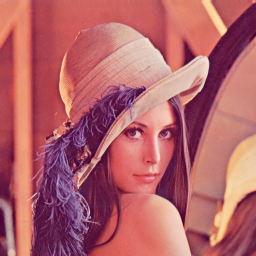

In [200]:
lena = testimage("lena_color_256")

compression ratio: 23.48%

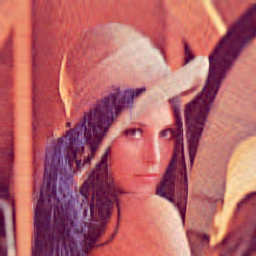

In [201]:
lena_c, lena_r = compress_image(lena, 30)
@printf("compression ratio: %.2f%%", lena_r * 100)
lena_c

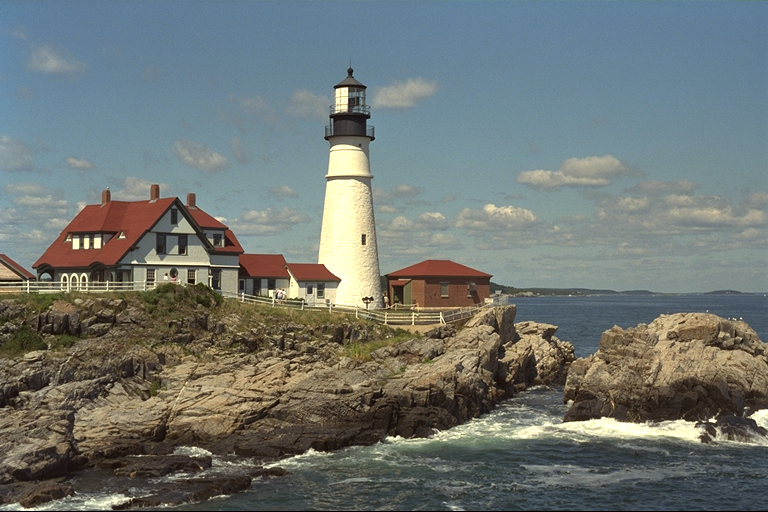

In [202]:
lighthouse = testimage("lighthouse")

compression ratio: 16.29%

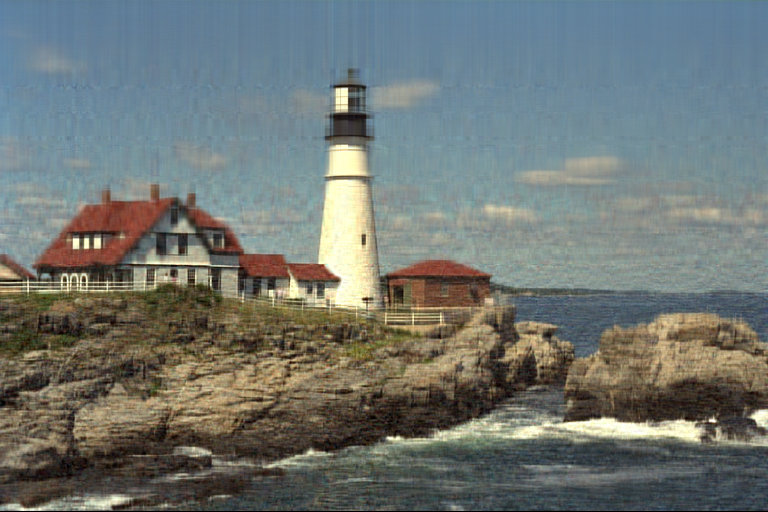

In [203]:
lighthouse_c, lighthouse_r = compress_image(lighthouse, 50)
@printf("compression ratio: %.2f%%", lighthouse_r * 100)
lighthouse_c